# Hierarchical Models

##### Keywords: hierarchical, bayesian, empirical bayes, rat tumors, partial pooling,  kidney cancer,  type-2 MLE, exchangeability, beta, binomial, beta-binomial

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')

## Contents
{:.no_toc}
* 
{: toc}

## Introduction
Here we set up and solve a hierarchical model analytically. In particular, we encounter 70 trials with varying numbers of rats, and the number of tumors observed in each trial.

We are tempted to fully pool the data to estimate the overall chance of getting a tumor, but we know that each trial may have been done with a rat lineage with a different propensity for developing tumors.

Even then, we might pool the data to 'average over' the different lineages. This may or may not be appropriate depending on whether the labs are a random sample of lineages, and other factors. Since we don't know whether it's legit, we'll stick with predicting the cancer rates for each trial, and use partial pooling to improve our estimates.

## An Example: Rats tumors (from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5)


The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number of rats that developed a tumor; the second is the total number or rats tested

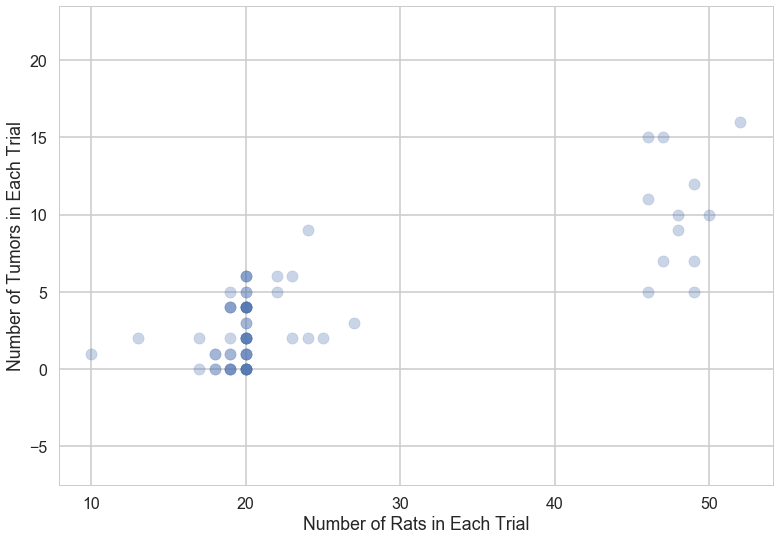

In [34]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])

plt.scatter(tumorn,tumory,alpha=.3)
plt.xlabel("Number of Rats in Each Trial")
plt.ylabel("Number of Tumors in Each Trial")
plt.axis('equal');

In [12]:
tumor_rate = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rate)
tvar = np.var(tumor_rate)
print("Mean Tumor Rate={:.3f}, Sample Variance {:0.3f}".format(tmean, tvar))

Mean Tumor Rate=0.136, Sample Variance 0.011


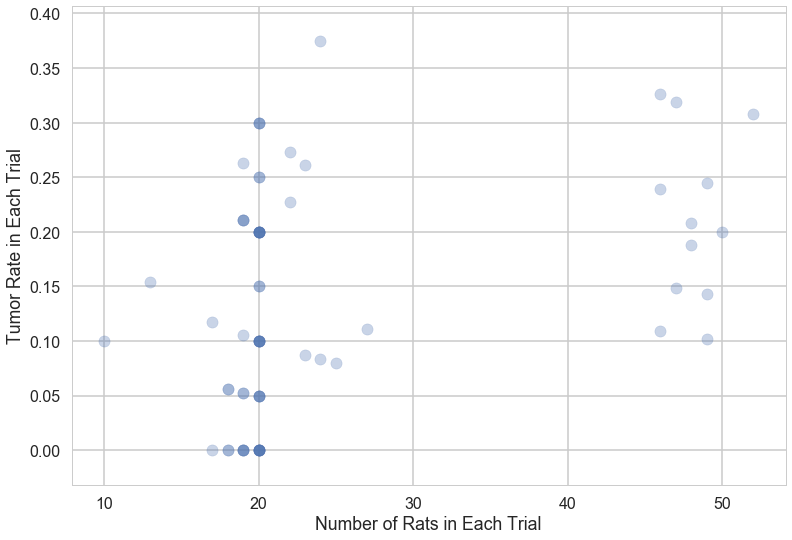

In [33]:
plt.scatter(tumorn,tumor_rate, alpha=.3)
plt.xlabel("Number of Rats in Each Trial")
plt.ylabel("Tumor Rate in Each Trial");

We can see that there's more variability in the observed tumor rate at lower trial sizes. We can also see that our assumption of different cancer rates from trial to trial may be questionable. But we'll press on with the hierarchical model and find out whether the posterior for the possible cancer rates in each trial is narrow.

## Partial pooling and the hierarchical model

Let's write out the structure for our model: the $\theta_i$s are drawn from a "population distribution" given by $Beta(\alpha, \beta)$, so chosen becuase it's conjugate with the binomial distribution that produces the observed $y_i$. We'll hold off on specifying the parameters $\alpha$ and $\beta$ (Gelman makes a couple of tranformations to find uninformative priors that are distracting from our purpose here).

$$ 
  \alpha \sim uninformative\ prior\\
  \beta \sim uninformative\ prior\\
  \theta_i \sim Beta(\alpha, \beta)\\
  y_i \sim Binom(n_i,\theta_i)\\
$$

This structure is shown in the diagram below.

![](images/rat-tumor-hier2.png)

(image from http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf)

## One Way of Fitting: Empirical Bayes
Emperical Bayes is a procedure for fitting a model, similar to the way Maximum Likelihood produces point estimates for each parameter. EB finds point estimates for the hyperparameters, thus nailing down the distribution of the $\theta_i$. This now-fixed prior will regularize our inferences about the individual $\theta_i$, and it will regularize them towards something that matches the data. It misses out a little compared to actauly finding the posterior of the $\alpha$ and $\beta$, but it can be much faster.

#### The usual plan
In order to pick $\alpha$ and $\beta$ that match the data, we need a function relating them. We want $p({y_i}|\alpha, \beta)$, the posterior-predictive distribution, with everything but $\alpha$ and $\beta$ integrated out. That is:

$$p(y \vert  D, \alpha,\beta) = \int  \, p(y \vert \theta) \, p(\theta \vert D, \alpha,\beta)\,d\theta$$

That math can be tough, so thank Bayes we picked a conjugate model: the posterior predictive for a beta binomial model is a... wait for it... beta-binomial distribution. (Yes, it's different from the beta, or the binomial)

$$p(y_i \vert  D, \alpha,\beta) = BetaBin(\alpha,\beta,n_i)$$

At this point we could write our the likelihood and find the MLE, we could do method of moments, we could pick two numbers out of a hat, but the point is we'd have estimates of $\alpha$ and $\beta$

#### Our shortcut
We cheat, and estimate the $\theta_i$ as the observed ratio of cancers and rats. Then we pick an $\alpha$ and $\beta$ by applying the method of moments to $p(\theta_i \vert  D, \alpha,\beta) = Beta(\alpha,\beta)$.

The final estimators are 

$$
  c= \frac{\mu(1-mu_o)}{\sigma_o^2 -1} \\
  \hat{\alpha} = c\mu_o \\
  \hat{\beta} = c(1-\mu_o)
$$

Where $\mu_o$ and $\sigma^2_o$ are the observed mean and variance of the various $\theta_i$.

It may be a sloppy way of estimating $\alpha$ and $\beta$, but it'll do.

In [11]:
aplusb = tmean*(1-tmean)/tvar - 1
a_est=aplusb*tmean
b_est=aplusb*(1.0 - tmean)
a_est, b_est

(1.3777748392916778, 8.7524354471531129)

#### Using the fitted values
We can now use these to compute the posterior means for all the experiments.

Since we have a conjugate model, the posterior for the $\theta$ is easy to find: it's just an edited beta distribution. For any values of $y_i$ and $n_i$:

$$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$$

If we want a point prediction, the posterior mean for a trial with $y_i$ and $n_i$ tumors and total rats is: $\bar{\theta}_{post, i} = \frac{\alpha + y_i}{\alpha + \beta + n_i}$

In [12]:
post_means = (a_est + tumory)/(a_est + b_est + tumorn)

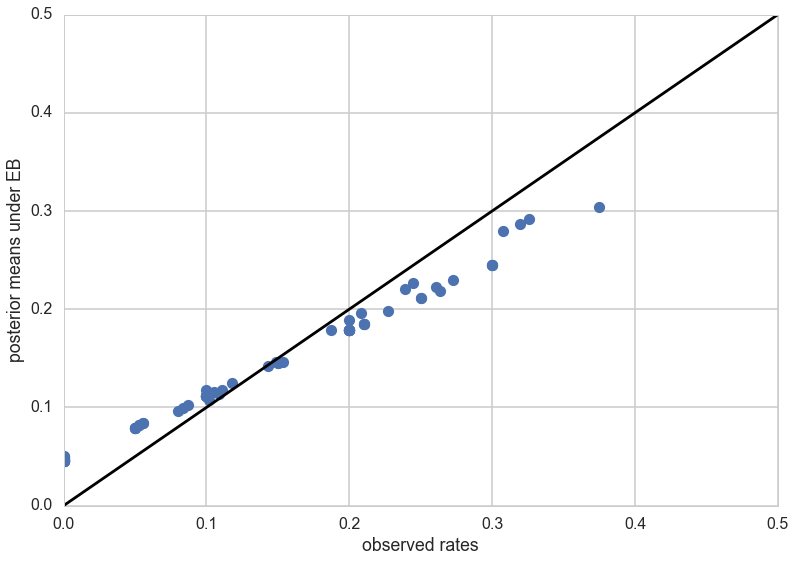

In [13]:
plt.plot(tumor_rate, post_means,'o')
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior means under EB");

As you can see, the posterior rates are shrunk towards flatness, which would correspond to complete pooling. The 45 degree line would be for completely unpooled estimate.

## Another Way of Fitting: Full Bayes
Empirical bayes is nice but suffers from the problem that one is still carrying out an optimization (finding $\alpha$ and $\beta$ that match the data), and every optimization is a chance to overfit. 

In the full [standard] bayes approach, we find full posterior distributions for $\alpha$ and $\beta$, rather than just finding point estimates. Since we'll now have the distribution of possible alpha and beta we're able to account for that uncertainty in our final estimates.

$$ 
  \alpha \sim Poisson(5)\\
  \beta \sim Poisson(5)\\
  \theta_i \sim Beta(\alpha, \beta)\\
  y_i \sim Binom(n_i,\theta_i)\\
$$

Note that the hyper-priors are the end of the chain: the distribution they come from has a fixed parameter value. We could go turtles all the way and create hyper-hyper-priors on the hyper-hyper-parameters of the hyper-prior. 

However, we typically use **uninformative hyperpriors** instead: indeed this is one of the key strategies of hierarchical modelling: un-informative priors are pushed down the prior hierarchy.

$$ 
  \alpha \sim uninformative\ prior\\
  \beta \sim uninformative\ prior\\
  \theta_i \sim Beta(\alpha, \beta)\\
  y_i \sim Binom(n_i,\theta_i)\\
$$

Uninformative priors are fully specified, i.e. thier parameters are fixed and not stochastic, so $\alpha$ and $\beta$ are the top of the chain.

#### Finding the Posteriors
We write out a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$.

$$p( \theta_i, \alpha, \beta | y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i | \alpha, \beta) \, p(y_i | \theta_i, n_i,\alpha, \beta)$$

For each of $\alpha$ and $\beta$, given everything else, the posterior distributions (assuming uninformative priors) can be shown to be:

$$p(\alpha | Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta | Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s.

Finding the joint posterior for $\alpha$ and $\beta$ isn't any easier.

## Closing down: Sampling to find the Joint Posterior
Now notice something: if $\alpha$ and $\beta$ are fixed I can easily sample from any of the 70 $\theta_i$s (just draw from a beta distribution with those parameters, it's line 3 of the model).

The sampling for $\alpha$ and $\beta$ given the other parameters is a bit more complex. We don't even know the normalizing constant. But that's never stopped our MCMC before. We can use the expressions above to get $\alpha$ and $\beta$ samples.

And hey! We have a few conditional distributions we can sample from, so to sample from the joint we can just cycle through them, Gibbs-style.

We will write the sampler for this model in lab.